In [1]:
##https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))


`-` GT: $f(x) = x \sin x$ (except noise)

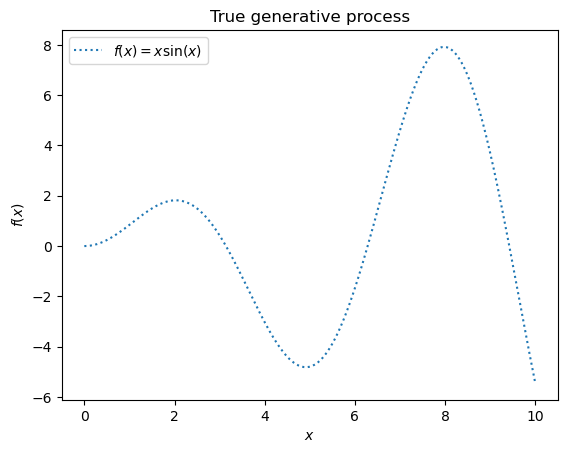

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")    ## Process라기보단 일단 함수

`-` 

In [9]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

## 커널 선택
# kernel = 1.0 * Matern(length_scale = 1.0, nu = 1.5, length_scale_bounds = (1e-2, 1e2))
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

> length_scale이 특정 범위 내에 존재한다고 가정하고 커널 만듦
>
> Matern은 k차 미분까지 가능하도록 nu를 설정

`-` std를 통해 Credible Interval 계산

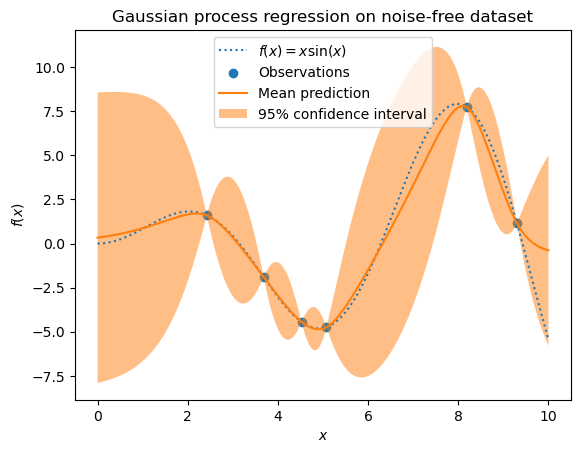

In [6]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

> Random에서 뽑아온 거라 관측치 계속 바뀜
>
> Kernel을 어떻게 선택하는지에 따라 결과가 크게 바뀜

`-` $f(x) = x \sin x + \epsilon$

In [10]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

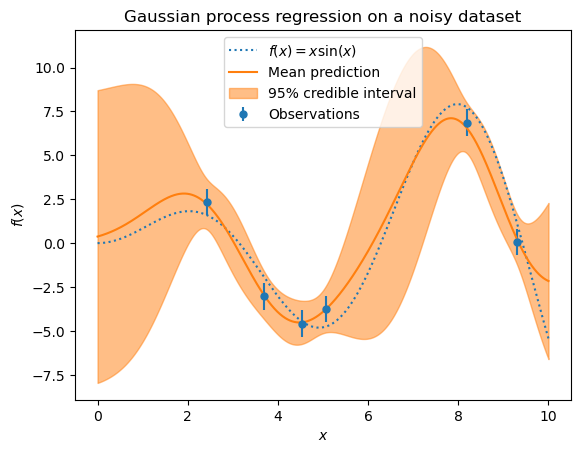

In [11]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% credible interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

## classification

In [ ]:
##https://krasserm.github.io/2020/11/04/gaussian-processes-classification/

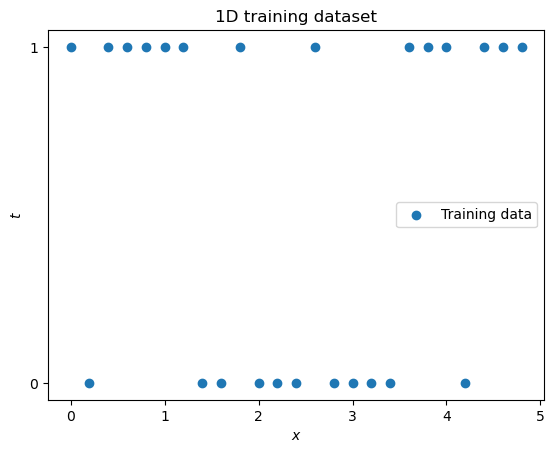

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# The package 'gaussian_processes_util' could not be found or installed, so its import and usage are removed.
# from gaussian_processes_util import (
#     plot_data_1D,
#     plot_data_2D,
#     plot_pt_2D,
#     plot_db_2D)

%matplotlib inline

np.random.seed(0)

X = np.arange(0, 5, 0.2).reshape(-1, 1)
X_test = np.arange(-2, 7, 0.1).reshape(-1, 1)

a = np.sin(X * np.pi * 0.5) * 2
t = bernoulli.rvs(sigmoid(a))

# Replaced plot_data_1D with matplotlib.pyplot.scatter
plt.figure()
plt.scatter(X, t, label='Training data')
plt.title('1D training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.legend()
plt.show()

In [13]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, t.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()['length_scale']
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

sklearn_theta_0, sklearn_theta_1, -gpc.log_marginal_likelihood_value_
print(f'Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}],negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta = [0.715, 0.836],negative log likelihood = 17.002


In [18]:
pt_test_gpc = gpc.predict_proba(X_test.reshape(-1, 1))[:,:]
print(pt_test_gpc)


[[0.49937423 0.50062577]
 [0.49908839 0.50091161]
 [0.49869321 0.50130679]
 [0.49815544 0.50184456]
 [0.49743441 0.50256559]
 [0.49648097 0.50351903]
 [0.49523633 0.50476367]
 [0.49363092 0.50636908]
 [0.49158328 0.50841672]
 [0.48899946 0.51100054]
 [0.48577323 0.51422677]
 [0.48178789 0.51821211]
 [0.47692055 0.52307945]
 [0.47105001 0.52894999]
 [0.46406912 0.53593088]
 [0.45590229 0.54409771]
 [0.44652795 0.55347205]
 [0.43600402 0.56399598]
 [0.42449285 0.57550715]
 [0.41227987 0.58772013]
 [0.39977967 0.60022033]
 [0.38752443 0.61247557]
 [0.3761338  0.6238662 ]
 [0.3662706  0.6337294 ]
 [0.35859126 0.64140874]
 [0.35370034 0.64629966]
 [0.35211484 0.64788516]
 [0.35423827 0.64576173]
 [0.3603395  0.6396605 ]
 [0.37053062 0.62946938]
 [0.38474102 0.61525898]
 [0.40269151 0.59730849]
 [0.42387907 0.57612093]
 [0.44758575 0.55241425]
 [0.47292232 0.52707768]
 [0.49890596 0.50109404]
 [0.52455851 0.47544149]
 [0.54900213 0.45099787]
 [0.57152981 0.42847019]
 [0.59163725 0.40836275]
